In [1]:
! pwd

/Users/imanithompson/Documents/Flatiron/Project/Job-Posting-Analysis/Notebooks


In [11]:
! ls ../../../../../Downloads/Data/fake_job_postings.csv

fake_job_postings.csv     training_set_features.csv training_set_labels.csv


#### Setting up notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, plot_roc_curve

In [2]:
from collections import defaultdict
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
import string
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,\
HashingVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [3]:
# Use this to download the stopwords if you haven't already - only ever needs to be run once
nltk.download("stopwords")

# Same with wordnet!
nltk.download('wordnet')

# And with parts of speech tagging!
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/imanithompson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/imanithompson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     /Users/imanithompson/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/imanithompson/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
data = pd.read_csv('../../../../../Downloads/Data/fake_job_postings.csv')

In [9]:
data.head()

job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving quality of life thro...   
4        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Food52, a fast-growing, James Beard Award-winn...   
1  Organised - Focused - Vibrant - Awesome!Do you...   
2  Our client, located in Houston, is actively se...   
3  THE COMPANY: ESRI – Environmental Systems Rese...   
4  JOB TITLE: Itemization Review ManagerLOCATION:...   

                                        requirements  \
0  Experience with content management systems a m...   
1  What we expect from you:Your key responsibilit...   
2  Implement pre-commissioning and commissioning ...   
3  EDUCATION: Bachelor’s or Master’s in GIS, busi...   
4  QUALIFICATIONS:RN license in the State of Texa...   

                                            benefits  telecommuting  \
0                                                NaN              0   
1  What you will get from usThrough being part of...              0   
2                                                NaN              0   
3  Our culture is anything but corporate—we have ...              0   
4                              Full Benefits Offered              0   

   has_company_logo  has_questions employment_type required_experience  \
0                 1              0           Other          Internship   
1                 1              0       Full-time      Not Applicable   
2                 1              0             NaN                 NaN   
3                 1              0       Full-time    Mid-Senior level   
4                 1              1       Full-time    Mid-Senior level   

  required_education                   industry              function  \
0                NaN                        NaN             Marketing   
1                NaN  Marketing and Advertising      Customer Service   
2                NaN                        NaN                   NaN   
3  Bachelor's Degree          Computer Software                 Sales   
4  Bachelor's Degree     Hospital & Health Care  Health Care Provider   

   fraudulent  
0           0  
1           0  
2           0  
3           0  
4           0

In [10]:
data.columns

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

In [11]:
data.shape #rows,columns

(17880, 18)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [13]:
data.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

## Salary range

In [14]:
list(data['salary_range'].value_counts().index)

['0-0',
 '40000-50000',
 '30000-40000',
 '45000-67000',
 '25000-30000',
 '30000-50000',
 '80000-100000',
 '35000-45000',
 '70000-90000',
 '50000-80000',
 '55000-75000',
 '50000-70000',
 '60000-80000',
 '30000-35000',
 '40000-45000',
 '40000-60000',
 '25000-35000',
 '50000-60000',
 '45000-50000',
 '40000-70000',
 '35000-40000',
 '100000-120000',
 '80000-120000',
 '18000-20000',
 '35000-50000',
 '80000-110000',
 '60000-75000',
 '30000-45000',
 '20000-25000',
 '20000-30000',
 '4500-4500',
 '140000-150000',
 '50000-65000',
 '65000-80000',
 '45000-60000',
 '55000-65000',
 '100000-150000',
 '70000-80000',
 '45000-55000',
 '90000-110000',
 '90000-120000',
 '60000-90000',
 '28000-32000',
 '20000-24000',
 '60000-70000',
 '25000-40000',
 '40000-100000',
 '60000-100000',
 '70000-100000',
 '45000-65000',
 '16000-18500',
 '35000-65000',
 '50000-55000',
 '40000-55000',
 '7200-1380000',
 '75000-100000',
 '100000-130000',
 '65000-75000',
 '20000-40000',
 '55000-70000',
 '65000-85000',
 '23000-28000',


In [15]:
data['salary_range'].value_counts()[0:57]

0-0              142
40000-50000       66
30000-40000       55
45000-67000       37
25000-30000       37
30000-50000       32
80000-100000      30
35000-45000       30
70000-90000       30
50000-80000       29
55000-75000       28
50000-70000       28
60000-80000       28
30000-35000       27
40000-45000       27
40000-60000       27
25000-35000       26
50000-60000       24
45000-50000       22
40000-70000       21
35000-40000       20
100000-120000     20
80000-120000      19
18000-20000       18
35000-50000       18
80000-110000      17
60000-75000       17
30000-45000       17
20000-25000       17
20000-30000       16
4500-4500         16
140000-150000     16
50000-65000       16
65000-80000       15
45000-60000       15
55000-65000       14
100000-150000     14
70000-80000       14
45000-55000       14
90000-110000      14
90000-120000      13
60000-90000       13
28000-32000       12
20000-24000       12
60000-70000       12
25000-40000       12
40000-100000      12
60000-100000 

In [16]:
data['salary_range'].value_counts().values[0:57]

array([142,  66,  55,  37,  37,  32,  30,  30,  30,  29,  28,  28,  28,
        27,  27,  27,  26,  24,  22,  21,  20,  20,  19,  18,  18,  17,
        17,  17,  17,  16,  16,  16,  16,  15,  15,  14,  14,  14,  14,
        14,  13,  13,  12,  12,  12,  12,  12,  11,  11,  11,  11,  11,
        10,  10,  10,  10,  10])

## Required experience

In [17]:
data['required_experience'].value_counts()

Mid-Senior level    3809
Entry level         2697
Associate           2297
Not Applicable      1116
Director             389
Internship           381
Executive            141
Name: required_experience, dtype: int64

## Department

In [18]:
list(data['department'].value_counts().index)

['Sales',
 'Engineering',
 'Marketing',
 'Operations',
 'IT',
 'Development',
 'Product',
 'Information Technology',
 'Technology',
 'Design',
 'Customer Service',
 'Finance',
 'HR',
 'tech',
 'R&D',
 'Creative',
 'Client Services',
 'Retail',
 'Product Development',
 'Business Development',
 'Oil and Gas',
 'Production',
 'CSD Relay',
 'Administrative',
 'Maintenance',
 'Human Resources',
 'Tech',
 'Accounting',
 'Technical',
 'Administration',
 'Clerical',
 'Editorial',
 'Oil & Energy',
 'Legal',
 'IT Services',
 'Department',
 'Performance Marketing',
 'Content',
 'Project Management',
 'Squiz ',
 'Admin',
 'Commercial',
 'QA',
 'Creative Services',
 'Engineering ',
 'Support',
 'International Growth',
 'Didactics',
 'All',
 'Customer Success',
 'Customer Support',
 'Management',
 'Marketing ',
 'CS',
 'Information Technology ',
 'Warehouse',
 'Product Team',
 'Engagement',
 'Education',
 'Product Innovation',
 'Sales ',
 'Permanent',
 'Account Management',
 'customer service',
 'Bu

In [19]:
# data['department'] = data['department'].replace('IT', "Technology").replace(
# 'Information Technology','Technology').replace('tech', 'Technology').replace(
# 'Technical', 'Technology').replace('Tech', 'Technology').replace(
# 'IT Services', 'Technology').replace('Information Technology ', 'Technology').replace(
# 'Technical Support', 'Technology')


# Had an good idea until I realized how time consuming this is 

In [20]:
data.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [21]:
list(data['industry'].value_counts().index)
# maybe drop departments all togehter BECAUSE OF ALL THE NULLS and have industry
# area in which your company is working

['Information Technology and Services',
 'Computer Software',
 'Internet',
 'Marketing and Advertising',
 'Education Management',
 'Financial Services',
 'Hospital & Health Care',
 'Consumer Services',
 'Telecommunications',
 'Oil & Energy',
 'Retail',
 'Real Estate',
 'Accounting',
 'Construction',
 'E-Learning',
 'Management Consulting',
 'Design',
 'Staffing and Recruiting',
 'Health, Wellness and Fitness',
 'Insurance',
 'Automotive',
 'Logistics and Supply Chain',
 'Human Resources',
 'Online Media',
 'Apparel & Fashion',
 'Legal Services',
 'Facilities Services',
 'Hospitality',
 'Computer Games',
 'Banking',
 'Building Materials',
 'Leisure, Travel & Tourism',
 'Nonprofit Organization Management',
 'Entertainment',
 'Electrical/Electronic Manufacturing',
 'Food & Beverages',
 'Cosmetics',
 'Airlines/Aviation',
 'Consumer Goods',
 'Consumer Electronics',
 'Medical Practice',
 'Public Relations and Communications',
 'Civic & Social Organization',
 'Market Research',
 'Transportati

In [22]:
data['function'].value_counts()
# but whats the difference between this and industry
# "your scope of work" within the company.

Information Technology    1749
Sales                     1468
Engineering               1348
Customer Service          1229
Marketing                  830
Administrative             630
Design                     340
Health Care Provider       338
Other                      325
Education                  325
Management                 317
Business Development       228
Accounting/Auditing        212
Human Resources            205
Project Management         183
Finance                    172
Consulting                 144
Writing/Editing            132
Art/Creative               132
Production                 116
Product Management         114
Quality Assurance          111
Advertising                 90
Business Analyst            84
Data Analyst                82
Public Relations            76
Manufacturing               74
General Business            68
Research                    50
Legal                       47
Strategy/Planning           46
Training                    38
Supply C

# As of now think of drop columns department and salary ranges and maybe droping all other null values

In [23]:
data.head()

job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving quality of life thro...   
4        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Food52, a fast-growing, James Beard Award-winn...   
1  Organised - Focused - Vibrant - Awesome!Do you...   
2  Our client, located in Houston, is actively se...   
3  THE COMPANY: ESRI – Environmental Systems Rese...   
4  JOB TITLE: Itemization Review ManagerLOCATION:...   

                                        requirements  \
0  Experience with content management systems a m...   
1  What we expect from you:Your key responsibilit...   
2  Implement pre-commissioning and commissioning ...   
3  EDUCATION: Bachelor’s or Master’s in GIS, busi...   
4  QUALIFICATIONS:RN license in the State of Texa...   

                                            benefits  telecommuting  \
0                                                NaN              0   
1  What you will get from usThrough being part of...              0   
2                                                NaN              0   
3  Our culture is anything but corporate—we have ...              0   
4                              Full Benefits Offered              0   

   has_company_logo  has_questions employment_type required_experience  \
0                 1              0           Other          Internship   
1                 1              0       Full-time      Not Applicable   
2                 1              0             NaN                 NaN   
3                 1              0       Full-time    Mid-Senior level   
4                 1              1       Full-time    Mid-Senior level   

  required_education                   industry              function  \
0                NaN                        NaN             Marketing   
1                NaN  Marketing and Advertising      Customer Service   
2                NaN                        NaN                   NaN   
3  Bachelor's Degree          Computer Software                 Sales   
4  Bachelor's Degree     Hospital & Health Care  Health Care Provider   

   fraudulent  
0           0  
1           0  
2           0  
3           0  
4           0

In [26]:
data['description'][0]

'Food52, a fast-growing, James Beard Award-winning online food community and crowd-sourced and curated recipe hub, is currently interviewing full- and part-time unpaid interns to work in a small team of editors, executives, and developers in its New York City headquarters.Reproducing and/or repackaging existing Food52 content for a number of partner sites, such as Huffington Post, Yahoo, Buzzfeed, and more in their various content management systemsResearching blogs and websites for the Provisions by Food52 Affiliate ProgramAssisting in day-to-day affiliate program support, such as screening affiliates and assisting in any affiliate inquiriesSupporting with PR &amp; Events when neededHelping with office administrative work, such as filing, mailing, and preparing for meetingsWorking with developers to document bugs and suggest improvements to the siteSupporting the marketing and executive staff'

In [27]:
data['requirements'][0]

'Experience with content management systems a major plus (any blogging counts!)Familiar with the Food52 editorial voice and aestheticLoves food, appreciates the importance of home cooking and cooking with the seasonsMeticulous editor, perfectionist, obsessive attention to detail, maddened by typos and broken links, delighted by finding and fixing themCheerful under pressureExcellent communication skillsA+ multi-tasker and juggler of responsibilities big and smallInterested in and engaged with social media like Twitter, Facebook, and PinterestLoves problem-solving and collaborating to drive Food52 forwardThinks big picture but pitches in on the nitty gritty of running a small company (dishes, shopping, administrative support)Comfortable with the realities of working for a startup: being on call on evenings and weekends, and working long hours'

### Nulls in description n requirements

In [5]:
data[['description', 'requirements']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   description   17879 non-null  object
 1   requirements  15185 non-null  object
dtypes: object(2)
memory usage: 279.5+ KB


In [6]:
data = data.dropna(subset=['description', 'requirements'])

In [7]:
data.isna().sum()

job_id                     0
title                      0
location                 170
department              9469
salary_range           12573
company_profile         2554
description                0
requirements               0
benefits                4786
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         2509
required_experience     5151
required_education      5971
industry                3526
function                4607
fraudulent                 0
dtype: int64

### combining description and requirements

In [8]:
data['words'] = data['description'] + ' ' + data['requirements']

In [57]:
data.head(1)

job_id             title          location department salary_range  \
0       1  Marketing Intern  US, NY, New York  Marketing          NaN   

                                     company_profile  \
0  We're Food52, and we've created a groundbreaki...   

                                         description  \
0  Food52, a fast-growing, James Beard Award-winn...   

                                        requirements benefits  telecommuting  \
0  Experience with content management systems a m...      NaN              0   

   has_company_logo  has_questions employment_type required_experience  \
0                 1              0           Other          Internship   

  required_education industry   function  fraudulent  \
0                NaN      NaN  Marketing           0   

                                               words  
0  Food52, a fast-growing, James Beard Award-winn...

In [58]:
data['words'][0]

'Food52, a fast-growing, James Beard Award-winning online food community and crowd-sourced and curated recipe hub, is currently interviewing full- and part-time unpaid interns to work in a small team of editors, executives, and developers in its New York City headquarters.Reproducing and/or repackaging existing Food52 content for a number of partner sites, such as Huffington Post, Yahoo, Buzzfeed, and more in their various content management systemsResearching blogs and websites for the Provisions by Food52 Affiliate ProgramAssisting in day-to-day affiliate program support, such as screening affiliates and assisting in any affiliate inquiriesSupporting with PR &amp; Events when neededHelping with office administrative work, such as filing, mailing, and preparing for meetingsWorking with developers to document bugs and suggest improvements to the siteSupporting the marketing and executive staff Experience with content management systems a major plus (any blogging counts!)Familiar with t

### start NLP vectorizing

In [9]:
sw = stopwords.words('english')

In [60]:
data.words

0        Food52, a fast-growing, James Beard Award-winn...
1        Organised - Focused - Vibrant - Awesome!Do you...
2        Our client, located in Houston, is actively se...
3        THE COMPANY: ESRI – Environmental Systems Rese...
4        JOB TITLE: Itemization Review ManagerLOCATION:...
                               ...                        
17875    Just in case this is the first time you’ve vis...
17876    The Payroll Accountant will focus primarily on...
17877    Experienced Project Cost Control Staff Enginee...
17878    Nemsia Studios is looking for an experienced v...
17879    Who are we?Vend is an award winning web based ...
Name: words, Length: 15185, dtype: object

In [83]:
data['words'][45]

'As a Sales Representative, you will provide assistance to our customers as they purchase the materials and tools they need for a wide variety of roofing, siding, and window/door replacement projects. From the moment you greet customers until their sales have been finalized, you will provide them with the best in customer service and exterior building supply expertise.Your specific duties as a Sales Representative may include:Determining customers’ needs and recommending appropriate products and solutionsFollowing ABC’s product/supply checklist for each customer’s specific job and upselling additional products and supplies for that jobAnswering customer questions and offering product adviceOrdering products from other ABC Supply branches when necessaryAccepting payment and applying it to the appropriate customer accountArranging with the warehouse for customer product pickupFollowing-up on each delivery to ensure that shipment arrived on time with all items accounted forBalancing out c

### Adding spaces before capital letters - Need to make a function out if it 

In [10]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer



[NLP Source](https://my.learn.co/courses/468/assignments/25568?module_item_id=61343)

In [129]:
# Create an intance of the RegexpTokenizer with the variable name `tokenizer`
# The regex pattern should select all words with three or more characters
pattern = r"(?u)\w{3,}"
tokenizer = RegexpTokenizer(pattern)

# Create a list of stopwords in English
stopwords_list = stopwords.words('english')

# Create an instance of nltk's PorterStemmer with the variable name `stemmer`
stemmer = nltk.stem.PorterStemmer()

def capital_words_spaces(str1, tokenizer, stopwords_list, stemmer):
    space_words= re.sub(r"(\w)([A-Z])", r"\1 \2", str1)
    # Standardize case (lowercase the text)
    lowered = space_words.lower()

    # Tokenize text using `tokenizer`
    tokens = tokenizer.tokenize(lowered)

    # Remove stopwords using `stopwords_list`
    stopped_tokens = [word for word in tokens if word not in stopwords_list]

    # Stem the tokenized text using `stemmer`
    stems = [stemmer.stem(token) for token in stopped_tokens]

    # Return the preprocessed text
    return stems

In [130]:
data['words'][2]

['client',
 'locat',
 'houston',
 'activ',
 'seek',
 'experienc',
 'commiss',
 'machineri',
 'assist',
 'possess',
 'strong',
 'supervisori',
 'skill',
 'attent',
 'detail',
 'strong',
 'dedic',
 'safeti',
 'must',
 'ideal',
 'candid',
 'execut',
 'activ',
 'compli',
 'qualiti',
 'requir',
 'health',
 'environment',
 'safeti',
 'regul',
 'implement',
 'pre',
 'commiss',
 'commiss',
 'procedur',
 'rotari',
 'equip',
 'execut',
 'activ',
 'subcontractor',
 'assign',
 'crew',
 'pertain',
 'disciplin',
 'ensur',
 'effect',
 'util',
 'commiss',
 'manpow',
 'consum',
 'ensur',
 'execut',
 'vendor',
 'specialist',
 'field',
 'activ',
 'assign',
 'resourc',
 'sub',
 'contractor',
 'per',
 'vendor',
 'repres',
 'plan',
 'carri',
 'equip',
 'inspect',
 'client',
 'repres',
 'ensur',
 'proper',
 'certif',
 'produc',
 'prepar',
 'form',
 'pend',
 'test',
 'submit',
 'sign',
 'certif',
 'final',
 'hand',
 'certif',
 'engin',
 'coordin',
 'field',
 'vendor',
 'repres',
 'keep',
 'record',
 'activ',


In [143]:
data.reset_index(drop=True)

job_id                                              title  \
0           1                                   Marketing Intern   
1           2          Customer Service - Cloud Video Production   
2           3            Commissioning Machinery Assistant (CMA)   
3           4                  Account Executive - Washington DC   
4           5                                Bill Review Manager   
...       ...                                                ...   
15180   17876                   Account Director - Distribution    
15181   17877                                 Payroll Accountant   
15182   17878  Project Cost Control Staff Engineer - Cost Con...   
15183   17879                                   Graphic Designer   
15184   17880                         Web Application Developers   

                   location   department salary_range  \
0          US, NY, New York    Marketing          NaN   
1            NZ, , Auckland      Success          NaN   
2             US, IA, Wever          NaN          NaN   
3        US, DC, Washington        Sales          NaN   
4        US, FL, Fort Worth          NaN          NaN   
...                     ...          ...          ...   
15180       CA, ON, Toronto        Sales          NaN   
15181  US, PA, Philadelphia   Accounting          NaN   
15182       US, TX, Houston          NaN          NaN   
15183         NG, LA, Lagos          NaN          NaN   
15184     NZ, N, Wellington  Engineering          NaN   

                                         company_profile  \
0      We're Food52, and we've created a groundbreaki...   
1      90 Seconds, the worlds Cloud Video Production ...   
2      Valor Services provides Workforce Solutions th...   
3      Our passion for improving quality of life thro...   
4      SpotSource Solutions LLC is a Global Human Cap...   
...                                                  ...   
15180  Vend is looking for some awesome new talent to...   
15181  WebLinc is the e-commerce platform and service...   
15182  We Provide Full Time Permanent Positions for m...   
15183                                                NaN   
15184  Vend is looking for some awesome new talent to...   

                                             description  \
0      Food52, a fast-growing, James Beard Award-winn...   
1      Organised - Focused - Vibrant - Awesome!Do you...   
2      Our client, located in Houston, is actively se...   
3      THE COMPANY: ESRI – Environmental Systems Rese...   
4      JOB TITLE: Itemization Review ManagerLOCATION:...   
...                                                  ...   
15180  Just in case this is the first time you’ve vis...   
15181  The Payroll Accountant will focus primarily on...   
15182  Experienced Project Cost Control Staff Enginee...   
15183  Nemsia Studios is looking for an experienced v...   
15184  Who are we?Vend is an award winning web based ...   

                                            requirements  \
0      Experience with content management systems a m...   
1      What we expect from you:Your key responsibilit...   
2      Implement pre-commissioning and commissioning ...   
3      EDUCATION: Bachelor’s or Master’s in GIS, busi...   
4      QUALIFICATIONS:RN license in the State of Texa...   
...                                                  ...   
15180  To ace this role you:Will eat comprehensive St...   
15181  - B.A. or B.S. in Accounting- Desire to have f...   
15182  At least 12 years professional experience.Abil...   
15183  1. Must be fluent in the latest versions of Co...   
15184  We want to hear from you if:You have an in-dep...   

                                                benefits  telecommuting  \
0                                                    NaN              0   
1      What you will get from usThrough being part of...              0   
2                                                    NaN              0   
3      Our culture is anything but corpora

In [131]:
for n,row in enumerate(data['words']):
    data['words'][n]=capital_words_spaces(row, tokenizer, stopwords_list, stemmer)

TypeError: expected string or bytes-like object

In [138]:
data['words'].head(20)

0     [food52, fast, grow, jame, beard, award, win, ...
1     [organis, focus, vibrant, awesom, passion, cus...
2     [client, locat, houston, activ, seek, experien...
3     [environment, system, research, institut, pass...
4     [item, review, manag, fort, worth, item, revie...
6     Your Responsibilities: Manage the English-spea...
7     Who is Airenvy?Hey there! We are seasoned entr...
8     Implementation/Configuration/Testing/Training ...
9     The Customer Service Associate will be based i...
10    Position : #URL_86fd830a95a64e2b30ceed829e63fd...
11    TransferWise is the clever new way to move mon...
12    The Applications Developer, Digital will devel...
13    Event Industry Installers Needed!! (Orlando, F...
14    Are you interested in a satisfying and financi...
15    About Vault Dragon Vault Dragon is Dropbox for...
16    We are looking for a Hands-On QA Leader for ou...
17    Government funding is only available for 16-18...
19    Experienced Process Controls Engineer is r

In [116]:
text = 'As a Sales Representative, you will provide assistance to our customers as they purchase the materials and tools they need for a wide variety of roofing, siding, and window/door replacement projects. From the moment you greet customers until their sales have been finalized, you will provide them with the best in customer service and exterior building supply expertise.Your specific duties as a Sales Representative may include:Determining customers’ needs and recommending appropriate products and solutionsFollowing ABC’s product/supply checklist for each customer’s specific job and upselling additional products and supplies for that jobAnswering customer questions and offering product adviceOrdering products from other ABC Supply branches when necessaryAccepting payment and applying it to the appropriate customer accountArranging with the warehouse for customer product pickupFollowing-up on each delivery to ensure that shipment arrived on time with all items accounted forBalancing out cash drawers and preparing bank deposits at the end of each dayArranging product displays and layouts to maximize effectivenessReordering products to keep the store and warehouse shelves well stockedGiving out comment cards to customersAddressing and resolving customer complaints when necessary As a Sales Representative, you must have the ability to provide superior customer service and to go the extra mile to determine and provide exactly what each customer needs. It helps if you have experience with exterior building supplies so that you are familiar with the various products and associated contractor terminology. As a Sales Representative, you will also need to be self-motivated with a strong work ethic and excellent attention to detail.Specific qualifications for the Sales Representative position include:1-2 years retail/customer service experience; experience with residential roofing and siding and windows (retail supply sales or site work with a crew) preferredStrong retail merchandising skills (including shelving and layout)Excellent verbal and written communication and interpersonal skillsSolid time management and prioritization skillsBasic computer skillsAbility to lift 50-75 pounds'
capital_words_spaces(text,tokenizer, stopwords_list, stemmer)

['sale',
 'repres',
 'provid',
 'assist',
 'custom',
 'purchas',
 'materi',
 'tool',
 'need',
 'wide',
 'varieti',
 'roof',
 'side',
 'window',
 'door',
 'replac',
 'project',
 'moment',
 'greet',
 'custom',
 'sale',
 'final',
 'provid',
 'best',
 'custom',
 'servic',
 'exterior',
 'build',
 'suppli',
 'expertis',
 'specif',
 'duti',
 'sale',
 'repres',
 'may',
 'includ',
 'determin',
 'custom',
 'need',
 'recommend',
 'appropri',
 'product',
 'solut',
 'follow',
 'product',
 'suppli',
 'checklist',
 'custom',
 'specif',
 'job',
 'upsel',
 'addit',
 'product',
 'suppli',
 'job',
 'answer',
 'custom',
 'question',
 'offer',
 'product',
 'advic',
 'order',
 'product',
 'suppli',
 'branch',
 'necessari',
 'accept',
 'payment',
 'appli',
 'appropri',
 'custom',
 'account',
 'arrang',
 'warehous',
 'custom',
 'product',
 'pickup',
 'follow',
 'deliveri',
 'ensur',
 'shipment',
 'arriv',
 'time',
 'item',
 'account',
 'balanc',
 'cash',
 'drawer',
 'prepar',
 'bank',
 'deposit',
 'end',
 'da

In [121]:
data.words[0]

['food52',
 'fast',
 'grow',
 'jame',
 'beard',
 'award',
 'win',
 'onlin',
 'food',
 'commun',
 'crowd',
 'sourc',
 'curat',
 'recip',
 'hub',
 'current',
 'interview',
 'full',
 'part',
 'time',
 'unpaid',
 'intern',
 'work',
 'small',
 'team',
 'editor',
 'execut',
 'develop',
 'new',
 'york',
 'citi',
 'headquart',
 'reproduc',
 'repackag',
 'exist',
 'food52',
 'content',
 'number',
 'partner',
 'site',
 'huffington',
 'post',
 'yahoo',
 'buzzfe',
 'variou',
 'content',
 'manag',
 'system',
 'research',
 'blog',
 'websit',
 'provis',
 'food52',
 'affili',
 'program',
 'assist',
 'day',
 'day',
 'affili',
 'program',
 'support',
 'screen',
 'affili',
 'assist',
 'affili',
 'inquiri',
 'support',
 'amp',
 'event',
 'need',
 'help',
 'offic',
 'administr',
 'work',
 'file',
 'mail',
 'prepar',
 'meet',
 'work',
 'develop',
 'document',
 'bug',
 'suggest',
 'improv',
 'site',
 'support',
 'market',
 'execut',
 'staff',
 'experi',
 'content',
 'manag',
 'system',
 'major',
 'plu',
 'bl

In [122]:
data['words']

0        [food52, fast, grow, jame, beard, award, win, ...
1        [organis, focus, vibrant, awesom, passion, cus...
2        [client, locat, houston, activ, seek, experien...
3        [environment, system, research, institut, pass...
4        [item, review, manag, fort, worth, item, revie...
                               ...                        
17875    Just in case this is the first time you’ve vis...
17876    The Payroll Accountant will focus primarily on...
17877    Experienced Project Cost Control Staff Enginee...
17878    Nemsia Studios is looking for an experienced v...
17879    Who are we?Vend is an award winning web based ...
Name: words, Length: 15185, dtype: object

In [114]:
capital_words_spaces('As a Sales Representative, you will provide assistance to our customers as they purchase the materials and tools they need for a wide variety of roofing, siding, and window/door replacement projects. From the moment you greet customers until their sales have been finalized, you will provide them with the best in customer service and exterior building supply expertise.Your specific duties as a Sales Representative may include:Determining customers’ needs and recommending appropriate products and solutionsFollowing ABC’s product/supply checklist for each customer’s specific job and upselling additional products and supplies for that jobAnswering customer questions and offering product adviceOrdering products from other ABC Supply branches when necessaryAccepting payment and applying it to the appropriate customer accountArranging with the warehouse for customer product pickupFollowing-up on each delivery to ensure that shipment arrived on time with all items accounted forBalancing out cash drawers and preparing bank deposits at the end of each dayArranging product displays and layouts to maximize effectivenessReordering products to keep the store and warehouse shelves well stockedGiving out comment cards to customersAddressing and resolving customer complaints when necessary As a Sales Representative, you must have the ability to provide superior customer service and to go the extra mile to determine and provide exactly what each customer needs. It helps if you have experience with exterior building supplies so that you are familiar with the various products and associated contractor terminology. As a Sales Representative, you will also need to be self-motivated with a strong work ethic and excellent attention to detail.Specific qualifications for the Sales Representative position include:1-2 years retail/customer service experience; experience with residential roofing and siding and windows (retail supply sales or site work with a crew) preferredStrong retail merchandising skills (including shelving and layout)Excellent verbal and written communication and interpersonal skillsSolid time management and prioritization skillsBasic computer skillsAbility to lift 50-75 pounds')


TypeError: capital_words_spaces() missing 3 required positional arguments: 'tokenizer', 'stopwords_list', and 'stemmer'

In [75]:
tf_vec1 = TfidfVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?,  r' \1', str)",
                         stop_words=sw)
X_vec1 = tf_vec1.fit_transform(data.words)  

df = pd.DataFrame(X_vec1.toarray(), columns=tf_vec1.get_feature_names())
df.head()

# Lindsey recommended the Count Vectorizer 

In [87]:
vec1 = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", 
                      stop_words=sw)

X_vec1 = vec1.fit_transform(data.words)

df1 = pd.DataFrame(X_vec1.toarray(), columns=vec1.get_feature_names())
df1.head()

aa  aaa  aaab  aaabe  aaacdddaae  aaadd  aaae  aaaf  aab  aabc  ...  zuora  \
0   0    0     0      0           0      0     0     0    0     0  ...      0   
1   0    0     0      0           0      0     0     0    0     0  ...      0   
2   0    0     0      0           0      0     0     0    0     0  ...      0   
3   0    0     0      0           0      0     0     0    0     0  ...      0   
4   0    0     0      0           0      0     0     0    0     0  ...      0   

   zur  zurb  zurich  zus  zusammen  zusammenarbeitest  zweig  zyfax  zynga  
0    0     0       0    0         0                  0      0      0      0  
1    0     0       0    0         0                  0      0      0      0  
2    0     0       0    0         0                  0      0      0      0  
3    0     0       0    0         0                  0      0      0      0  
4    0     0       0    0         0                  0      0      0      0  

[5 rows x 80739 columns]

In [89]:
data.loc[45].words

'As a Sales Representative, you will provide assistance to our customers as they purchase the materials and tools they need for a wide variety of roofing, siding, and window/door replacement projects. From the moment you greet customers until their sales have been finalized, you will provide them with the best in customer service and exterior building supply expertise.Your specific duties as a Sales Representative may include:Determining customers’ needs and recommending appropriate products and solutions Following A BC’s product/supply checklist for each customer’s specific job and upselling additional products and supplies for that job Answering customer questions and offering product advice Ordering products from other A BC Supply branches when necessary Accepting payment and applying it to the appropriate customer account Arranging with the warehouse for customer product pickup Following-up on each delivery to ensure that shipment arrived on time with all items accounted for Balanc

In [92]:
df1.loc[45].sort_values(ascending=False)

customer                         5
work                             5
service                          4
experience                       4
year                             3
                                ..
preferredproven                  0
preferredpublic                  0
preferredqualificationsproven    0
preferredquickbooks              0
aa                               0
Name: 45, Length: 80739, dtype: int64

## Starting completely from beginning

In [18]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


In [19]:
def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from the satire corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    # print(doc)
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [12]:
data.head(1)

job_id             title          location department salary_range  \
0       1  Marketing Intern  US, NY, New York  Marketing          NaN   

                                     company_profile  \
0  We're Food52, and we've created a groundbreaki...   

                                         description  \
0  Food52, a fast-growing, James Beard Award-winn...   

                                        requirements benefits  telecommuting  \
0  Experience with content management systems a m...      NaN              0   

   has_company_logo  has_questions employment_type required_experience  \
0                 1              0           Other          Internship   

  required_education industry   function  fraudulent  \
0                NaN      NaN  Marketing           0   

                                               words  
0  Food52, a fast-growing, James Beard Award-winn...

In [13]:
data[['description', 'requirements']].isna().sum()

description     0
requirements    0
dtype: int64

### Description

In [15]:
data.description

0        Food52, a fast-growing, James Beard Award-winn...
1        Organised - Focused - Vibrant - Awesome!Do you...
2        Our client, located in Houston, is actively se...
3        THE COMPANY: ESRI – Environmental Systems Rese...
4        JOB TITLE: Itemization Review ManagerLOCATION:...
                               ...                        
17875    Just in case this is the first time you’ve vis...
17876    The Payroll Accountant will focus primarily on...
17877    Experienced Project Cost Control Staff Enginee...
17878    Nemsia Studios is looking for an experienced v...
17879    Who are we?Vend is an award winning web based ...
Name: description, Length: 15185, dtype: object

In [21]:
X = data.description
y = data.fraudulent

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.25)

In [22]:
token_docs = [doc_preparer(doc, sw) for doc in X_train]

In [23]:
X_train.iloc[0]

'Pinnatta, οne of the fastest growing Greek startups,\xa0is looking for an ingenious Marketing Analyst to join our Marketing team in Athens and particiapte in the evolution of our innovative service.The company is backed up by US, Russian, Chinese and Greek investors and retains offices in Silicon Valley (California, US) and Athens (Greece).\xa0If you have a very strong belief that data is the key to success and want to become part of an extremely talented team, with global aspect and huge potential, feel free to contact us!\xa0As a Marketing Analyst in Pinnatta, you will be responsible for providing information and insights regarding customers, markets, competitors and campaign effectiveness to measure performance and support business decisions. The ideal candidate will have experience planning and managing various research projects and be able to work closely to the senior management team to\xa0interpret findingsResponsibilities:Provide ROI analysis of all marketing campaigns and sal

In [24]:
token_docs[0]

'pinnatta ne fast grow greek startup look ingenious market analyst join marketing team athens particiapte evolution innovative service company back u russian chinese greek investor retain office silicon valley california u athens greece strong belief data key success want become part extremely talented team global aspect huge potential feel free contact u market analyst pinnatta responsible provide information insight regard customer market competitor campaign effectiveness measure performance support business decision ideal candidate experience plan manage various research project able work closely senior management team interpret findingsresponsibilities provide roi analysis marketing campaign sale activitiesdesign research project answer specific business questionsunderstand business objective design survey discover prospective customer preferenceswork product management identify new market opportunity work beta customer complete concept test new feature productsconduct market resea

In [25]:
token_docs

['pinnatta ne fast grow greek startup look ingenious market analyst join marketing team athens particiapte evolution innovative service company back u russian chinese greek investor retain office silicon valley california u athens greece strong belief data key success want become part extremely talented team global aspect huge potential feel free contact u market analyst pinnatta responsible provide information insight regard customer market competitor campaign effectiveness measure performance support business decision ideal candidate experience plan manage various research project able work closely senior management team interpret findingsresponsibilities provide roi analysis marketing campaign sale activitiesdesign research project answer specific business questionsunderstand business objective design survey discover prospective customer preferenceswork product management identify new market opportunity work beta customer complete concept test new feature productsconduct market rese

In [26]:
# Secondary train-test split to build our best model
X_t, X_val, y_t, y_val = train_test_split(token_docs, y_train,
                                          test_size=0.25, random_state=42)

#### Multinomial Naive Bayes

In [31]:
y_t.value_counts()
# 0 - no
# 1 - yes, less fraud 

0    8137
1     404
Name: fraudulent, dtype: int64

In [29]:
prior_0 = y_t.value_counts()[0]/len(y_t)
prior_1 = y_t.value_counts()[1]/len(y_t)
print(prior_0, prior_1)

0.9526987472192952 0.047301252780704836


In [32]:
mnb.class_log_prior_

array([-0.04845654, -3.0512185 ])

In [33]:
np.log(prior_0)

-0.04845653524949

#### Count Vectorizer

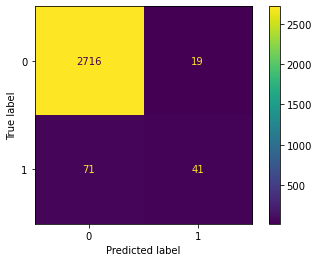

In [41]:
cv = CountVectorizer()
X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

# We then transform the validation set. (Do not refit the vectorizer!)
X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)
y_hat = mnb.predict(X_val_vec)
plot_confusion_matrix(mnb, X_val_vec, y_val);

In [83]:
X_t_vec.value_counts()

aa  aaa  aaadd  aaae  aaaf  aab  aabc  aabd  aabe  aabf  aac  aaca  aacae  aacb  aacbf  aaccd  aacute  aad  aada  aadb  aadbece  aadd  aadfc  aae  aaea  aaec  aaece  aaf  aafcf  aafeea  aafes  aan  aanbieden  aanvang  aap  aarki  aarna  aaron  aart  aat  ab        aba  abac  abad  abadcc  abakus  abandon  abandonment  abap  abaqus  abatement  abb  abba  abbb  abbf  abc       abcae  abcd  abcdeb  abce  abcorporate  abd  abdab  abdcd  abdd  abdominal  abe  abee  abeef  aberdeen  aberdeenjob  aberdeenshire  aberdeenshirepriority  abergele  abf  abfceafd  abfe  abi  abide  abilities  abilitiesability  abilitiesacting  abilitiesapplies  abilitiesexcellent  abilitiesfamiliarity  abilitiesmaintain  abilitiespreferred  abilitiesstrong  abilitiestake  ability  abilityadvanced  abilitypossess  abl  able  abn  abnormal  aboard  aboutact  aboutat  abouthello  aboutmopp  abouttyba  aboutwhat  abranded  abreast  abroad  abs  absa  absence  absent  absolut  absolute  absolutely  absolutelyno  absorb 

In [38]:
accuracy_score(y_val, y_hat)
precision_score(y_val, y_hat)
print(f'accuracy score {accuracy_score(y_val, y_hat)}')
print(f'precision score {precision_score(y_val, y_hat)}')

accuracy score 0.9683877766069547
precision score 0.6833333333333333


In [40]:
len(cv.vocabulary_)

33952

#### Tfidf Vectorizer

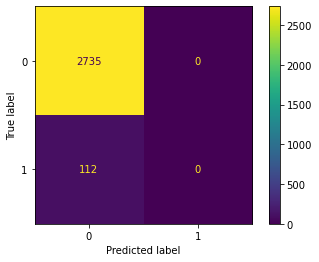

In [46]:
tfidf = TfidfVectorizer()
X_t_vec_t = tfidf.fit_transform(X_t)
X_t_vec_t  = pd.DataFrame.sparse.from_spmatrix(X_t_vec_t)
X_t_vec_t.columns = sorted(tfidf.vocabulary_)
X_t_vec_t.set_index(y_t.index, inplace=True)

X_val_vec_t = tfidf.transform(X_val)
X_val_vec_t = pd.DataFrame.sparse.from_spmatrix(X_val_vec_t)
X_val_vec_t.columns = sorted(tfidf.vocabulary_)
X_val_vec_t.set_index(y_val.index, inplace=True)

# mnb = MultinomialNB()

mnb.fit(X_t_vec_t, y_t)
y_hat_t = mnb.predict(X_val_vec_t)
plot_confusion_matrix(mnb, X_val_vec_t, y_val);

In [52]:
print(f'accuracy score {accuracy_score(y_val, y_hat_t)}')
print(f'precision score {precision_score(y_val, y_hat_t)}')

accuracy score 0.9606603442219881
precision score 0.0


### Requirements

In [53]:
data.requirements

0        Experience with content management systems a m...
1        What we expect from you:Your key responsibilit...
2        Implement pre-commissioning and commissioning ...
3        EDUCATION: Bachelor’s or Master’s in GIS, busi...
4        QUALIFICATIONS:RN license in the State of Texa...
                               ...                        
17875    To ace this role you:Will eat comprehensive St...
17876    - B.A. or B.S. in Accounting- Desire to have f...
17877    At least 12 years professional experience.Abil...
17878    1. Must be fluent in the latest versions of Co...
17879    We want to hear from you if:You have an in-dep...
Name: requirements, Length: 15185, dtype: object

In [54]:
X = data.requirements
y = data.fraudulent

X_trainR, X_testR, y_trainR, y_testR = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.25)

In [55]:
token_docsR = [doc_preparer(doc, sw) for doc in X_trainR]

In [56]:
X_trainR.iloc[0]

'2+ years experience in a marketing or market research positionExceptional knowledge of marketing, sales and business processesStrong project management, business writing and reporting skillsAbility to develop strong relationships and work with executivesExceptional written and verbal communication skills (in English)Strong presentation skillsSolid management, analytical and problem-solving skillsExperience with business intelligence and reporting softwareAdequate knowledge of data collection methods (polls, surveys, focus groups etc)Effective time management, organizational and leadership skillsAbility to interpret large amounts of dataTeam player'

In [57]:
token_docsR[0]

'year experience market market research positionexceptional knowledge marketing sale business processesstrong project management business write report skillsability develop strong relationship work executivesexceptional write verbal communication skill english strong presentation skillssolid management analytical problem solve skillsexperience business intelligence report softwareadequate knowledge data collection method poll survey focus group etc effective time management organizational leadership skillsability interpret large amount datateam player'

In [59]:
token_docsR

['year experience market market research positionexceptional knowledge marketing sale business processesstrong project management business write report skillsability develop strong relationship work executivesexceptional write verbal communication skill english strong presentation skillssolid management analytical problem solve skillsexperience business intelligence report softwareadequate knowledge data collection method poll survey focus group etc effective time management organizational leadership skillsability interpret large amount datateam player',
 'ideal candidate hold degree accounting year experience account receivable similar industry preferred candidate must fluent ms office application type excel intermediate advance level pivot table must data entry provide general admin support necessarygeneral must havesstrong communication skillsexcellent customer service skillsanalytical organizational skillsattention detailability multi taskseeking someone day per weekincrease hour n

In [60]:
# Secondary train-test split to build our best model
X_tR, X_valR, y_tR, y_valR = train_test_split(token_docsR, y_trainR,
                                          test_size=0.25, random_state=42)

#### Multinomial Naive Bayes

In [64]:
y_tR.value_counts()
# 0 - no
# 1 - yes, less fraud 

0    8137
1     404
Name: fraudulent, dtype: int64

In [65]:
prior_0 = y_tR.value_counts()[0]/len(y_tR)
prior_1 = y_tR.value_counts()[1]/len(y_tR)
print(prior_0, prior_1)

0.9526987472192952 0.047301252780704836


In [66]:
mnb.class_log_prior_

array([-0.04845654, -3.0512185 ])

In [67]:
np.log(prior_0)

-0.04845653524949

#### Count Vectorizer

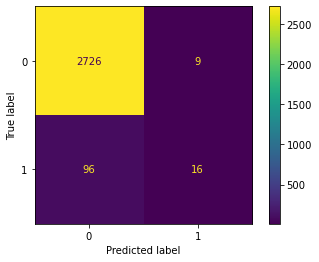

In [68]:
cv = CountVectorizer()
X_t_vecR = cv.fit_transform(X_tR)
X_t_vecR  = pd.DataFrame.sparse.from_spmatrix(X_t_vecR)
X_t_vecR.columns = sorted(cv.vocabulary_)
X_t_vecR.set_index(y_tR.index, inplace=True)

# We then transform the validation set. (Do not refit the vectorizer!)
X_val_vecR = cv.transform(X_valR)
X_val_vecR  = pd.DataFrame.sparse.from_spmatrix(X_val_vecR)
X_val_vecR.columns = sorted(cv.vocabulary_)
X_val_vecR.set_index(y_valR.index, inplace=True)

mnb = MultinomialNB()

mnb.fit(X_t_vecR, y_tR)
y_hatR = mnb.predict(X_val_vecR)
plot_confusion_matrix(mnb, X_val_vecR, y_valR);

In [69]:
print(f'accuracy score {accuracy_score(y_valR, y_hatR)}')
print(f'precision score {precision_score(y_valR, y_hatR)}')

accuracy score 0.9631190727081138
precision score 0.64


Description alone is better than requirement scores for count vec

#### Tfidf Vectorizer

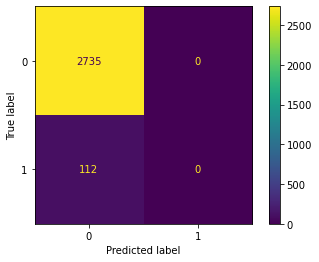

In [70]:
tfidf = TfidfVectorizer()
X_t_vec_R = tfidf.fit_transform(X_tR)
X_t_vec_R  = pd.DataFrame.sparse.from_spmatrix(X_t_vec_R)
X_t_vec_R.columns = sorted(tfidf.vocabulary_)
X_t_vec_R.set_index(y_tR.index, inplace=True)

X_val_vec_R = tfidf.transform(X_valR)
X_val_vec_R = pd.DataFrame.sparse.from_spmatrix(X_val_vec_R)
X_val_vec_R.columns = sorted(tfidf.vocabulary_)
X_val_vec_R.set_index(y_valR.index, inplace=True)

# mnb = MultinomialNB()

mnb.fit(X_t_vec_R, y_tR)
y_hat_R = mnb.predict(X_val_vec_R)
plot_confusion_matrix(mnb, X_val_vec_R, y_valR);

In [75]:
print(f'accuracy score {accuracy_score(y_valR, y_hat_R)}')
print(f'precision score {precision_score(y_valR, y_hat_R)}')

accuracy score 0.9606603442219881
precision score 0.0


/Users/imanithompson/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Why is this the same as description ????

### Description and Requirements

In [78]:
data.words

0        Food52, a fast-growing, James Beard Award-winn...
1        Organised - Focused - Vibrant - Awesome!Do you...
2        Our client, located in Houston, is actively se...
3        THE COMPANY: ESRI – Environmental Systems Rese...
4        JOB TITLE: Itemization Review ManagerLOCATION:...
                               ...                        
17875    Just in case this is the first time you’ve vis...
17876    The Payroll Accountant will focus primarily on...
17877    Experienced Project Cost Control Staff Enginee...
17878    Nemsia Studios is looking for an experienced v...
17879    Who are we?Vend is an award winning web based ...
Name: words, Length: 15185, dtype: object

In [80]:
data.words[1]

"Organised - Focused - Vibrant - Awesome!Do you have a passion for customer service? Slick typing skills? Maybe Account Management? ...And think administration is cooler than a polar bear on a jetski? Then we need to hear you!\xa0We are the Cloud Video Production Service and opperating on a glodal level. Yeah, it's pretty cool. Serious about\xa0delivering a world class product and excellent customer service.Our rapidly expanding business is looking for a talented Project Manager to manage the successful delivery of video projects, manage client communications and drive the production process. Work with some of the coolest brands on the planet and learn from a global team that are representing NZ is a huge way!We are entering the next growth stage of our business and growing quickly internationally. \xa0Therefore, the position is bursting with opportunity for the right person entering the business at the right time.\xa090 Seconds, the worlds Cloud Video Production Service -\xa0http://90

In [ ]:
X = data.word
y = data.fraudulent

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.25)



In [ ]:
X = data.description
y = data.fraudulent

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.25)

token_docs = [doc_preparer(doc, sw) for doc in X_train]

X_train.iloc[0]

token_docs[0]

token_docs

# Secondary train-test split to build our best model
X_t, X_val, y_t, y_val = train_test_split(token_docs, y_train,
                                          test_size=0.25, random_state=42)

#### Multinomial Naive Bayes